Can experience and age predict hours played?

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
source('cleanup.R')

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [3]:
players <- read_csv('players.csv')

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
players_tidy <- players |>
    na.omit() |>
    mutate(experience = as_factor(experience)) |>
    select(experience, Age, played_hours)
players_tidy

experience,Age,played_hours
<fct>,<dbl>,<dbl>
Pro,9,30.3
Veteran,17,3.8
Veteran,17,0.0
Amateur,21,0.7
Regular,21,0.1
Amateur,17,0.0
Regular,19,0.0
Amateur,21,0.0
Amateur,17,0.1


In [5]:
experience_playtime_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_player_hours = mean(played_hours))
experience_playtime_means

experience,mean_player_hours
<fct>,<dbl>
Pro,2.7846154
Veteran,0.6479167
Amateur,6.0174603
Regular,18.7257143
Beginner,1.2485714


In [6]:
experience_age_means <- players_tidy |>
    group_by(experience) |>
    summarize(mean_age = mean(Age))
experience_age_means

experience,mean_age
<fct>,<dbl>
Pro,16.92308
Veteran,20.95833
Amateur,20.25397
Regular,20.60000
Beginner,21.65714


In [7]:
players_split <- initial_split(players_tidy, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

In [8]:
players_recipe <- recipe(played_hours ~ Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_vfold = vfold_cv(players_train, v = 5, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec_tune)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [9]:
gridvals <- tibble(neighbors = seq(from = 1, to = 12, by = 1))

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,27.40567,5,9.404073,Preprocessor1_Model01
2,rmse,standard,28.09876,5,10.297883,Preprocessor1_Model02
3,rmse,standard,29.54172,5,9.077191,Preprocessor1_Model03
4,rmse,standard,28.57014,5,9.238194,Preprocessor1_Model04
5,rmse,standard,29.02272,5,9.592055,Preprocessor1_Model05
6,rmse,standard,29.38590,5,9.007586,Preprocessor1_Model06
7,rmse,standard,29.64801,5,8.686923,Preprocessor1_Model07
8,rmse,standard,28.19505,5,8.815798,Preprocessor1_Model08
9,rmse,standard,28.38679,5,8.659712,Preprocessor1_Model09


In [10]:
players_min <- players_results |>
    filter(mean == min(mean))
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,27.40567,5,9.404073,Preprocessor1_Model01


In [11]:
players_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 4) |>
    set_engine('kknn') |>
    set_mode('regression')

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

players_summary <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,11.78892


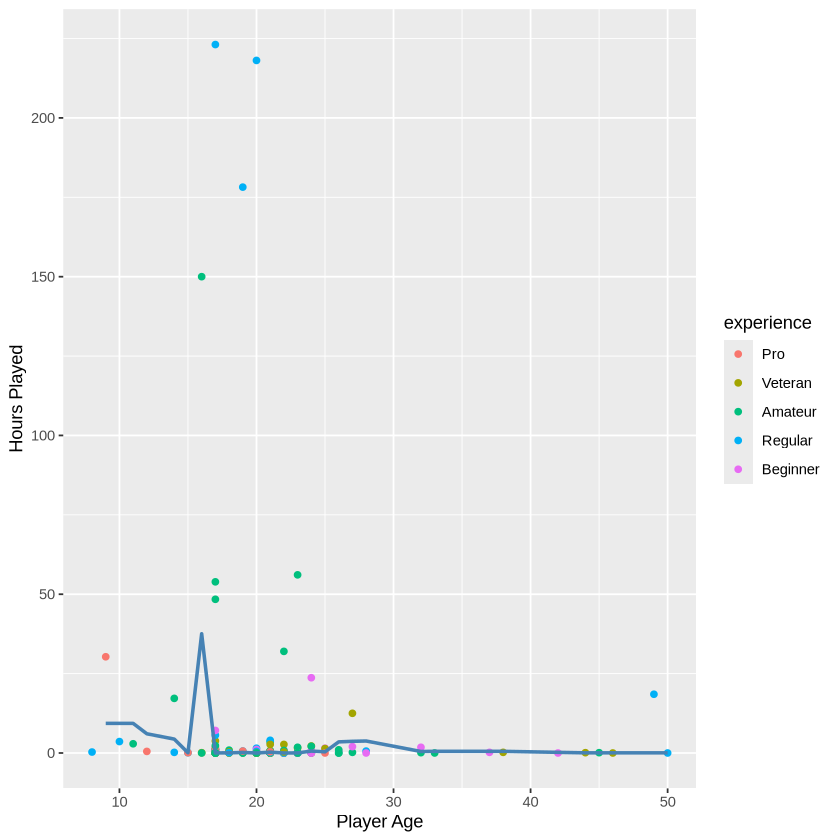

In [12]:
players_preds <- predict(players_fit, players_train) |>
        bind_cols(players_train)

players_plot <- ggplot(players_tidy, aes(x = Age, y = played_hours, color = experience)) +
  geom_point() +
  geom_line(data = players_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Hours Played")

players_plot

In [13]:
players_preds |>
    arrange(Age)

.pred,experience,Age,played_hours
<dbl>,<fct>,<dbl>,<dbl>
9.325,Pro,9,30.3
9.325,Regular,10,3.6
9.325,Amateur,11,2.9
6.050,Pro,12,0.5
4.375,Amateur,14,17.2
0.075,Regular,15,0.1
0.075,Pro,15,0.1
37.550,Veteran,16,0.1
37.550,Amateur,16,0.0


In [14]:
regulars <- players_tidy |>
    filter(experience == 'Regular')

regulars_split <- initial_split(regulars, prop = 0.75, strata = played_hours)
regulars_train <- training(regulars_split)
regulars_test <- testing(regulars_split)

regulars_recipe <- recipe(played_hours ~ Age, data = regulars_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

regulars_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

regulars_vfold = vfold_cv(regulars_train, v = 5, strata = played_hours)

regulars_workflow <- workflow() |>
    add_recipe(regulars_recipe) |>
    add_model(regulars_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 12, by = 1))

regulars_results <- regulars_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
regulars_min <- regulars_results |>
    filter(mean == min(mean))
regulars_min

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”
Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,27.40567,5,9.404073,Preprocessor1_Model01


In [15]:
regulars

experience,Age,played_hours
<fct>,<dbl>,<dbl>
Regular,21,0.1
Regular,19,0.0
Regular,19,0.6
Regular,8,0.3
Regular,28,0.6
Regular,17,0.0
Regular,17,5.6
Regular,23,0.0
Regular,20,218.1


In [31]:
players_real <- players_tidy |>
    filter(played_hours != 0)

players_real_split <- initial_split(players_real, prop = 0.75, strata = played_hours)
players_real_train <- training(players_real_split)
players_real_test <- testing(players_real_split)

players_real_recipe <- recipe(played_hours ~ Age, data = players_real_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_real_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')

players_real_vfold = vfold_cv(players_real_train, v = 5, strata = played_hours)

players_real_workflow <- workflow() |>
    add_recipe(players_real_recipe) |>
    add_model(players_real_spec_tune)

gridvals <- tibble(neighbors = seq(from = 1, to = 32, by = 1))

players_real_results <- players_real_workflow |>
  tune_grid(resamples = players_real_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")
players_real_min <- players_real_results |>
    filter(mean == min(mean))
players_real_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
24,rmse,standard,23.35382,5,7.369844,Preprocessor1_Model24


In [32]:
players_real_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = 24) |>
    set_engine('kknn') |>
    set_mode('regression')

players_real_fit <- workflow() |>
    add_recipe(players_real_recipe) |>
    add_model(players_real_spec) |>
    fit(data = players_real_train)

players_real_summary <- players_real_fit |>
  predict(players_real_test) |>
  bind_cols(players_real_test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_real_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,58.34643


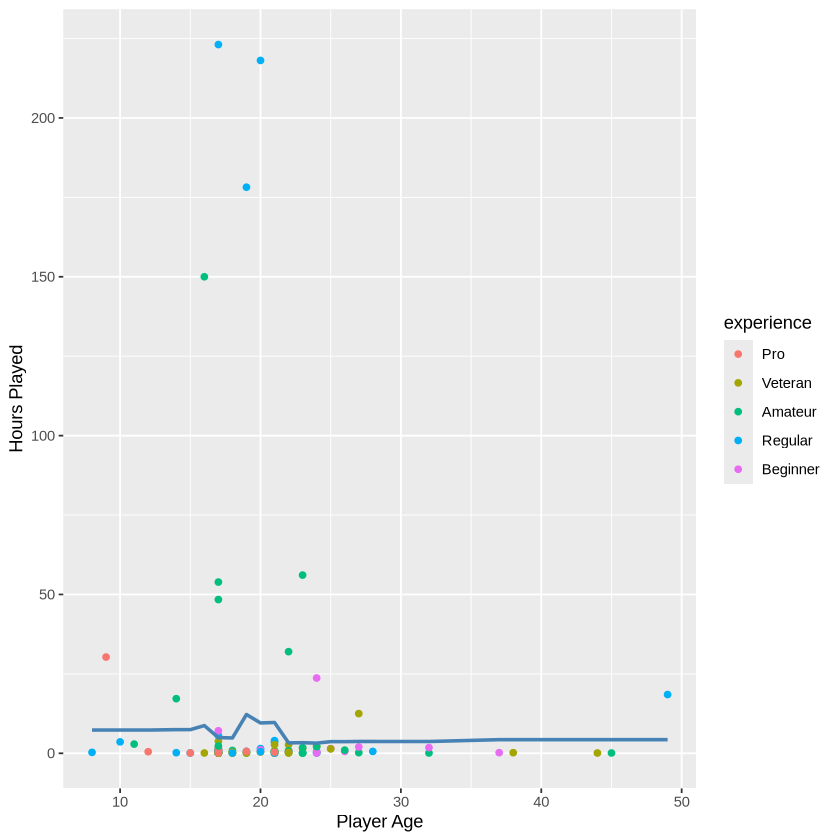

In [33]:
players_real_preds <- predict(players_real_fit, players_real_train) |>
        bind_cols(players_real_train)

players_real_plot <- ggplot(players_real, aes(x = Age, y = played_hours, color = experience)) +
  geom_point() +
  geom_line(data = players_real_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Hours Played")

players_real_plot

In [34]:
players_real_preds |>
    arrange(Age)

.pred,experience,Age,played_hours
<dbl>,<fct>,<dbl>,<dbl>
7.320833,Regular,8,0.3
7.320833,Regular,10,3.6
7.320833,Pro,12,0.5
7.458333,Regular,14,0.2
7.458333,Amateur,14,17.2
7.445833,Regular,15,0.1
7.445833,Pro,15,0.1
8.725000,Veteran,16,0.1
8.725000,Amateur,16,150.0
